code based on: [how-to-align-faces-with-opencv-in-python](https://datahacker.rs/010-how-to-align-faces-with-opencv-in-python/)

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

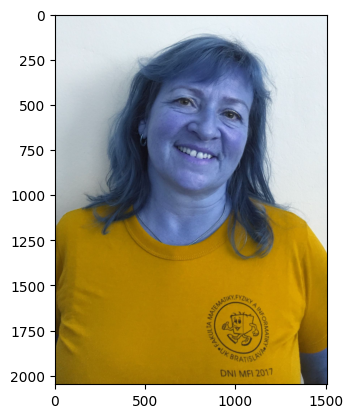

In [24]:
img = cv2.imread('./kdmfi-kjp-ktvs-turany/photos/leginusova1-ktvs.jpg')
plt.imshow(img)

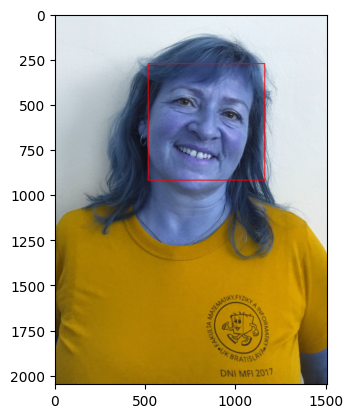

In [25]:
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grayscale, 1.1, 4)

# in case more faces were detected select the largest one (maybe try to get confidence out of detectMultiScale)
face = max(faces, key=lambda contour: contour[2] * contour[3])

x , y,  w,  h = face
cv2.rectangle(img, (x,y) ,(x+w, y+h), (255,0,0), 3)
plt.imshow(img)

113 967 354 967


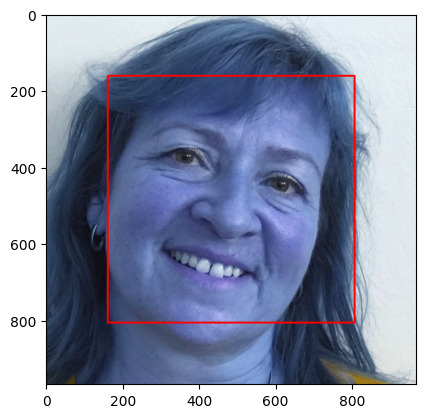

In [26]:
# crop picture to show only head area (detected face and some neighbourhood)
x , y,  w,  h = face
center_x, center_y = x + w // 2, y + h // 2

scaling_ratio = 1.5
W = int(w * scaling_ratio)
H = int(h * scaling_ratio)
X = center_x - W//2
Y = center_y - H//2

cropped_face = img[Y:Y+H, X:X+W]
plt.imshow(cropped_face)

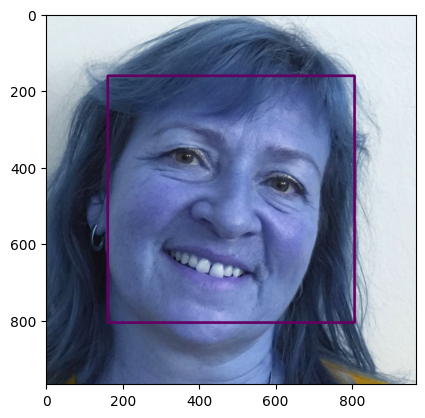

In [27]:
# adjust detected `face` coords to the new dimensions

face[0] = (W - w)//2
face[1] = (H - h)//2

x , y,  w,  h = face
cv2.rectangle(cropped_face, (x,y) ,(x+w, y+h), (100,0,100), 5)
plt.imshow(cropped_face)

In [28]:
x , y,  w,  h = face
grayscale = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)
roi_gray = grayscale[y:(y+h), x:(x+w)]
roi_color = cropped_face[y:(y+h), x:(x+w)]

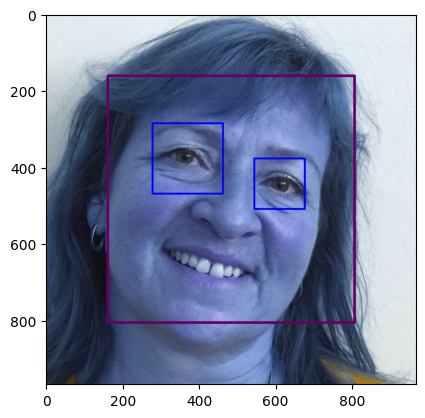

In [29]:
# detect eyes
eyes = eye_cascade.detectMultiScale(roi_gray, 1.05, 4)

# select contours that are located in the upper half of the face
eyes = [(ex , ey,  ew,  eh) for  (ex , ey,  ew,  eh) in eyes if ey < (h//2)]

# select the two largest contours
eyes = sorted(eyes, key=lambda contour: contour[2] * contour[3])[-3:]

left_eye, right_eye = eyes if eyes[0][0] < eyes[1][0] else eyes[::-1]

for (ex , ey,  ew,  eh) in eyes:
    cv2.rectangle(roi_color, (ex,ey) ,(ex+ew, ey+eh), (0,0,255), 3)

plt.imshow(cropped_face)

In [30]:
# get the centers of eyes
left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
left_eye_x = left_eye_center[0]
left_eye_y = left_eye_center[1]

right_eye_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)
right_eye_x = right_eye_center[0]
right_eye_y = right_eye_center[1]

cv2.circle(roi_color, left_eye_center, 5, (255, 0, 0) , -1)
cv2.circle(roi_color, right_eye_center, 5, (255, 0, 0) , -1)
cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)

array([[[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]],

       [[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]],

       [[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]],

       ...,

       [[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]],

       [[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]],

       [[100,   0, 100],
        [100,   0, 100],
        [100,   0, 100],
        ...,
        [100,   0, 100],
        [100,   0, 100],
        [100,   0, 100]]

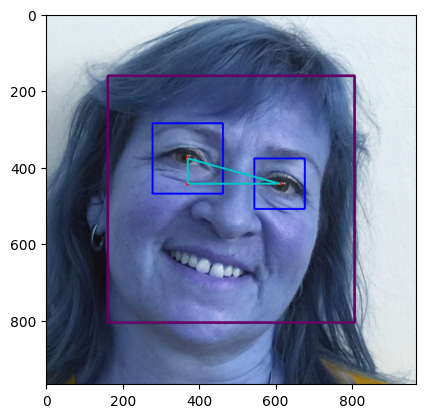

In [31]:
if left_eye_y > right_eye_y:
   A = right_eye_x, left_eye_y
   direction = -1
else:
   A = left_eye_x, right_eye_y
   direction = 1

cv2.circle(roi_color, A, 5, (255, 0, 0) , -1)
cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
cv2.line(roi_color,left_eye_center, A,(0,200,200),3)
cv2.line(roi_color,right_eye_center, A,(0,200,200),3)
plt.imshow(cropped_face)

In [32]:
# calculate the rotation angle
delta_x = right_eye_x - left_eye_x
delta_y = right_eye_y - left_eye_y
angle = np.arctan(delta_y/delta_x)
angle = (angle * 180) / np.pi

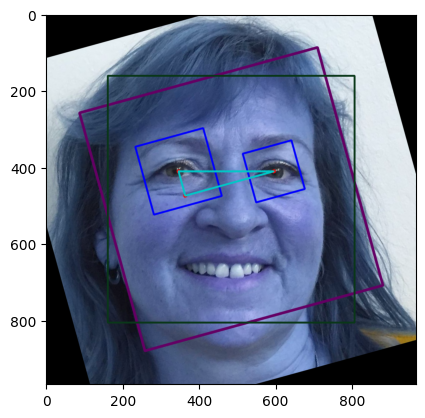

In [33]:
h, w = cropped_face.shape[:2]
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, angle, 1.0)

rotated = cv2.warpAffine(cropped_face, M, (w, h))
face_rotated = [center[0] - face[2]//2, center[1] - face[3]//2, face[2], face[3]]

x, y, w, h = face_rotated
cv2.rectangle(rotated, (x,y) ,(x+w, y+h), (10,55,25), 3)
plt.imshow(rotated)

### TODO:
- position the bounding box so that the nose (halfway the line connecting the eyes) is centered
- define the aspect ratio
- define the size of the final cropped image

In [34]:
ratio = None
h = None
w = None

# dim = (int(w * ratio), int(h * ratio))
# resized = cv2.resize(rotated, dim)
# plt.imshow(resized)